# Rock Music Genre Predictor

## Importing Data

Start by setting up the notebook and the dataframe

In [1]:
#import everything that is necessary for this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#create dataframe from the dataset
df = pd.read_csv("music_genre.csv")
#import data for future table joins
keys = pd.read_csv("key.csv")
modes = pd.read_csv("mode.csv")
genres = pd.read_csv("genre.csv")

In [2]:
#deletes the columns
df = df.drop(columns=['instance_id', "artist_name", "track_name", "obtained_date"])

#show types of each feature
print(df.dtypes)

#displays what is left
df.describe().transpose()

popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
valence             float64
music_genre          object
dtype: object


,count,mean,std,min,25%,50%,75%,max
popularity,50000.0,44.220420,15.542008,0.000000,34.0000,45.000000,56.000000,99.000
acousticness,50000.0,0.306383,0.341340,0.000000,0.0200,0.144000,0.552000,0.996
danceability,50000.0,0.558241,0.178632,0.059600,0.4420,0.568000,0.687000,0.986
duration_ms,50000.0,221252.602860,128671.957157,-1.000000,174800.0000,219281.000000,268612.250000,4830606.000
energy,50000.0,0.599755,0.264559,0.000792,0.4330,0.643000,0.815000,0.999
instrumentalness,50000.0,0.181601,0.325409,0.000000,0.0000,0.000158,0.155000,0.996
liveness,50000.0,0.193896,0.161637,0.009670,0.0969,0.126000,0.244000,1.000
loudness,50000.0,-9.133761,6.162990,-47.046000,-10.8600,-7.276500,-5.173000,3.744
speechiness,50000.0,0.093586,0.101373,0.022300,0.0361,0.048900,0.098525,0.942
valence,50000.0,0.456264,0.247119,0.000000,0.2570,0.448000,0.648000,0.992


In [3]:
#using inner table joins, enumerate the columns that use strings. This will add the enumerated columns
df = pd.merge(df,keys,on="key")
df = pd.merge(df,modes,on="mode")
df = pd.merge(df,genres,on="music_genre")
#remove the original columns, leaving only the enumerated ones
df = df.drop(columns=["key", "mode", "music_genre"])
df.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_index,mode_index,genre_index,genre_orig
0,27.0,0.004680,0.652,-1.0,0.941,0.7920,0.115,-5.201,0.0748,100.889,0.7590,2.0,0.0,0.0,2.0
1,37.0,0.203000,0.769,429941.0,0.551,0.8820,0.109,-12.520,0.0408,?,0.0618,2.0,0.0,0.0,2.0
2,37.0,0.009290,0.617,-1.0,0.896,0.0776,0.526,-0.317,0.1900,149.92,0.5460,2.0,0.0,0.0,2.0
3,47.0,0.000409,0.567,188764.0,0.898,0.6130,0.249,-1.286,0.1250,74.995,0.1830,2.0,0.0,0.0,2.0
4,38.0,0.002260,0.657,174227.0,0.709,0.6300,0.200,-6.533,0.0579,80.499,0.7790,2.0,0.0,0.0,2.0


In [4]:
df["tempo"] = df["tempo"].apply(lambda x: np.nan if x == "?" else x)
df["tempo"] = pd.to_numeric(df["tempo"])
df.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_index,mode_index,genre_index,genre_orig
0,27.0,0.004680,0.652,-1.0,0.941,0.7920,0.115,-5.201,0.0748,100.889,0.7590,2.0,0.0,0.0,2.0
1,37.0,0.203000,0.769,429941.0,0.551,0.8820,0.109,-12.520,0.0408,NaN,0.0618,2.0,0.0,0.0,2.0
2,37.0,0.009290,0.617,-1.0,0.896,0.0776,0.526,-0.317,0.1900,149.920,0.5460,2.0,0.0,0.0,2.0
3,47.0,0.000409,0.567,188764.0,0.898,0.6130,0.249,-1.286,0.1250,74.995,0.1830,2.0,0.0,0.0,2.0
4,38.0,0.002260,0.657,174227.0,0.709,0.6300,0.200,-6.533,0.0579,80.499,0.7790,2.0,0.0,0.0,2.0


In [5]:
print(df.dtypes)

popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
key_index           float64
mode_index          float64
genre_index         float64
genre_orig          float64
dtype: object


## Exploratory Data Analysis

make a scatter plot of the raw data
make a histogram of how many rows are in each class
box plots of some of your most predictive features
null counts by column
could take it further with some kmeans or knn clustering to see if the clusters align with specific music genres

### Null and Duplicated Counts

In [6]:
hf = df.loc[np.isnan(df['tempo'])]
print(len(hf.index))


4980


In [7]:
hf = df.loc[df['duration_ms'] <= 0]
print(len(hf.index))

4939


In [8]:
hf = hf.loc[np.isnan(hf['tempo'])]
print(len(hf.index))

479


In [9]:
df.isna().sum()

popularity             0
acousticness           0
danceability           0
duration_ms            0
energy                 0
instrumentalness       0
liveness               0
loudness               0
speechiness            0
tempo               4980
valence                0
key_index              0
mode_index             0
genre_index            0
genre_orig             0
dtype: int64

In [10]:
print(df.duplicated().sum())

1


### Predictive features

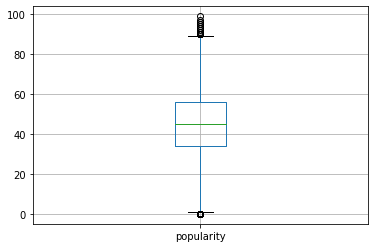

In [11]:
plot = df.boxplot(column=['popularity'])

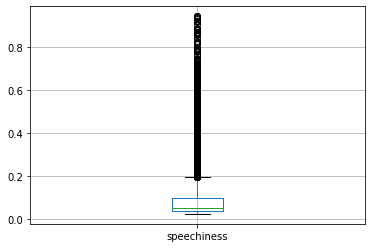

In [12]:
plot = df.boxplot(column=['speechiness'])

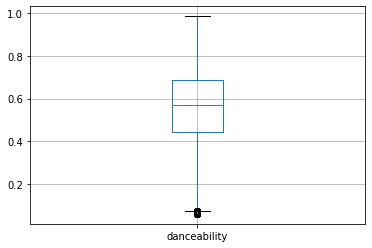

In [13]:
plot = df.boxplot(column=['danceability'])

### Features with Missing Data

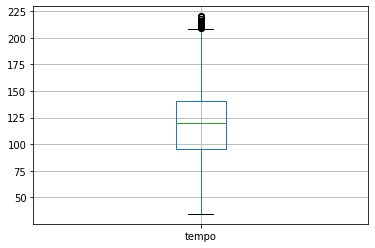

In [14]:
plot = df.boxplot(column=['tempo'])

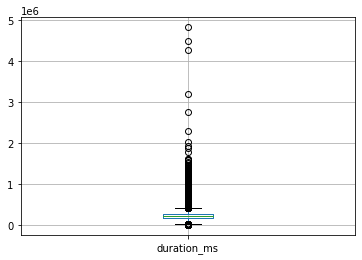

In [15]:
plot = df.boxplot(column=['duration_ms'])

### Key

array([[<AxesSubplot:title={'center':'key_index'}>]], dtype=object)

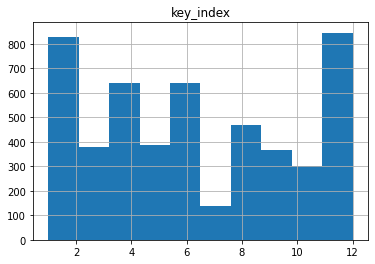

In [16]:
hf = df.loc[df['genre_index'] == 1]
hf.hist(column='key_index')

array([[<AxesSubplot:title={'center':'key_index'}>]], dtype=object)

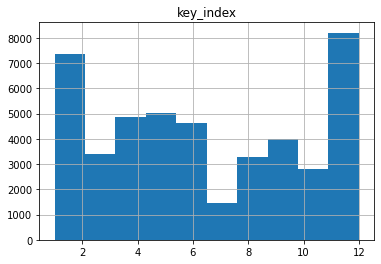

In [17]:
hf = df.loc[df['genre_index'] == 0]
hf.hist(column='key_index')

These graphs show the distribution of keys of songs for each genre. Although most keys are evenly split amongst genres, however there seems to be a bit of a difference in the 7th key and a big difference in the 5th key (Being D# and C# respectively). This shows that if the key of a song is D# or C# then it is more likely to belong in the rock genre.

### Mode

array([[<AxesSubplot:title={'center':'mode_index'}>]], dtype=object)

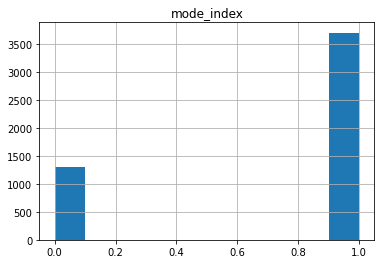

In [18]:
hf = df.loc[df['genre_index'] == 1]
hf.hist(column='mode_index')

array([[<AxesSubplot:title={'center':'mode_index'}>]], dtype=object)

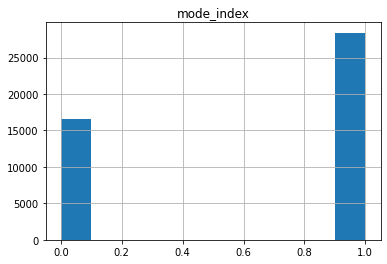

In [19]:
hf = df.loc[df['genre_index'] == 0]
hf.hist(column='mode_index')

This shows that if a song has a mode of 0 (minor) it is less likely to be a rock song.

### Distribution checks

array([[<AxesSubplot:title={'center':'genre_orig'}>]], dtype=object)

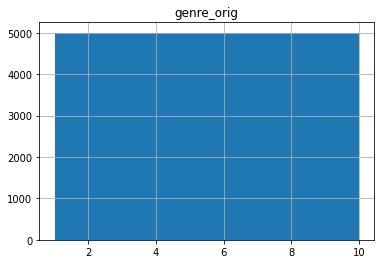

In [20]:
df.hist(column='genre_orig')

This shows how many songs of each genre are in the dataset, this confirms that it is an even distribution.

array([[<AxesSubplot:title={'center':'genre_orig'}>]], dtype=object)

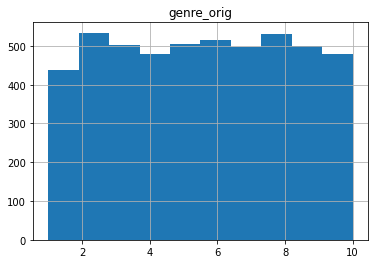

In [21]:
hf = df.loc[np.isnan(df['tempo'])]
hf.hist(column='genre_orig')

This is a graph of the distribution of missing values for the tempo column. This shows that the distribution of missing values is mostly random.

array([[<AxesSubplot:title={'center':'genre_orig'}>]], dtype=object)

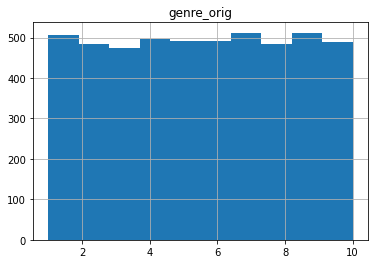

In [22]:
hf = df.loc[df['duration_ms'] <= 0]
hf.hist(column='genre_orig')

In [23]:
df = df.drop(columns=['genre_orig'])

This is a graph of the distribution of missing values for the duration_ms column. This shows that the distribution of missing values is mostly random.

## Feature Engineering

I chose to delete the columns below because they were all information about the song rather than details of the song itself.

The above table shows that loudness has both negative and positive values, since I eventually want all parameters to be between zero and one, I want to shift this. I also want to change the key, mode, and genre to numbers rather than objects so they will appear and can be normalized.

In [24]:
minimum = df['loudness'].min() * -1
df['loudness'] = df['loudness'] + minimum

Now Time to enumerate all of the object rows

In [25]:
df.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_index,mode_index,genre_index
0,27.0,0.004680,0.652,-1.0,0.941,0.7920,0.115,41.845,0.0748,100.889,0.7590,2.0,0.0,0.0
1,37.0,0.203000,0.769,429941.0,0.551,0.8820,0.109,34.526,0.0408,NaN,0.0618,2.0,0.0,0.0
2,37.0,0.009290,0.617,-1.0,0.896,0.0776,0.526,46.729,0.1900,149.920,0.5460,2.0,0.0,0.0
3,47.0,0.000409,0.567,188764.0,0.898,0.6130,0.249,45.760,0.1250,74.995,0.1830,2.0,0.0,0.0
4,38.0,0.002260,0.657,174227.0,0.709,0.6300,0.200,40.513,0.0579,80.499,0.7790,2.0,0.0,0.0


In the Exploratory Data section under Distribution Checks, the graphs show that the data is missing at random. Since it is MAR, I wanted to use either the mean, median, or mode. As the data is at least somewhat skewed (Exploratory Data, Features with Missing Data) and is all numerical, I decided to use the median for imputation,

In [26]:
df['tempo'] = df['tempo'].replace(np.nan, df['tempo'].median())

df['duration_ms'] = df['duration_ms'].apply(lambda x: df['duration_ms'].median() if x <= 0 else x)

df.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_index,mode_index,genre_index
0,27.0,0.004680,0.652,219281.0,0.941,0.7920,0.115,41.845,0.0748,100.889,0.7590,2.0,0.0,0.0
1,37.0,0.203000,0.769,429941.0,0.551,0.8820,0.109,34.526,0.0408,119.879,0.0618,2.0,0.0,0.0
2,37.0,0.009290,0.617,219281.0,0.896,0.0776,0.526,46.729,0.1900,149.920,0.5460,2.0,0.0,0.0
3,47.0,0.000409,0.567,188764.0,0.898,0.6130,0.249,45.760,0.1250,74.995,0.1830,2.0,0.0,0.0
4,38.0,0.002260,0.657,174227.0,0.709,0.6300,0.200,40.513,0.0579,80.499,0.7790,2.0,0.0,0.0


In [27]:
print(df.dtypes)

popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
key_index           float64
mode_index          float64
genre_index         float64
dtype: object


The table above shows that now each feature is a float.

In [28]:
#show data after all changes
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
popularity,50000.0,44.220420,15.542008,0.000000,34.00000,45.000000,56.000000,99.000
acousticness,50000.0,0.306383,0.341340,0.000000,0.02000,0.144000,0.552000,0.996
danceability,50000.0,0.558241,0.178632,0.059600,0.44200,0.568000,0.687000,0.986
duration_ms,50000.0,242913.278820,106075.316348,15509.000000,194875.00000,219281.500000,268612.250000,4830606.000
energy,50000.0,0.599755,0.264559,0.000792,0.43300,0.643000,0.815000,0.999
instrumentalness,50000.0,0.181601,0.325409,0.000000,0.00000,0.000158,0.155000,0.996
liveness,50000.0,0.193896,0.161637,0.009670,0.09690,0.126000,0.244000,1.000
loudness,50000.0,37.912239,6.162990,0.000000,36.18600,39.769500,41.873000,50.790
speechiness,50000.0,0.093586,0.101373,0.022300,0.03610,0.048900,0.098525,0.942
tempo,50000.0,119.945594,29.075705,34.347000,96.77575,119.879000,139.468250,220.276


The table above shows that all the data looks to now be in a useable form, however it still needs to be normalized.

In [29]:
#makes it easy to separate the target from everything else
target = ['genre_index']
predictors = list(set(list(df.columns))-set(target))
#normalize data
df[predictors] = df[predictors]/df[predictors].max()

Now I wanted to remove all missing values from the DataFrame and double check by looking to see if the counts of each feature match.

In [30]:
#Removes missing values
df = df.dropna()
#Use count column to verify
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
popularity,50000.0,0.446671,0.156990,0.000000,0.343434,0.454545,0.565657,1.0
acousticness,50000.0,0.307613,0.342711,0.000000,0.020080,0.144578,0.554217,1.0
danceability,50000.0,0.566167,0.181168,0.060446,0.448276,0.576065,0.696755,1.0
duration_ms,50000.0,0.050286,0.021959,0.003211,0.040342,0.045394,0.055606,1.0
energy,50000.0,0.600355,0.264824,0.000793,0.433433,0.643644,0.815816,1.0
instrumentalness,50000.0,0.182330,0.326716,0.000000,0.000000,0.000159,0.155622,1.0
liveness,50000.0,0.193896,0.161637,0.009670,0.096900,0.126000,0.244000,1.0
loudness,50000.0,0.746451,0.121343,0.000000,0.712463,0.783018,0.824434,1.0
speechiness,50000.0,0.099349,0.107615,0.023673,0.038323,0.051911,0.104591,1.0
tempo,50000.0,0.544524,0.131997,0.155927,0.439339,0.544222,0.633152,1.0


In [31]:
print(df.duplicated().sum())

1370


In [32]:
df = df.drop_duplicates()
print(df.duplicated().sum())

0


After changing around the features, the variance can be used to make sure to use the most impactful features.

In [33]:
df.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_index,mode_index,genre_index
0,0.272727,0.004699,0.661258,0.045394,0.941942,0.795181,0.115,0.823883,0.079406,0.458012,0.765121,0.166667,0.0,0.0
1,0.373737,0.203815,0.779919,0.089004,0.551552,0.885542,0.109,0.679779,0.043312,0.544222,0.062298,0.166667,0.0,0.0
2,0.373737,0.009327,0.625761,0.045394,0.896897,0.077912,0.526,0.920043,0.201699,0.680601,0.550403,0.166667,0.0,0.0
3,0.474747,0.000411,0.575051,0.039077,0.898899,0.615462,0.249,0.900965,0.132696,0.340459,0.184476,0.166667,0.0,0.0
4,0.383838,0.002269,0.666329,0.036067,0.709710,0.632530,0.200,0.797657,0.061465,0.365446,0.785282,0.166667,0.0,0.0


In [34]:
from sklearn.feature_selection import VarianceThreshold
#create the threshold
vt = VarianceThreshold(threshold=.01)
#remove features with a low variance
vt.fit(df)
#grab the column names
mask = vt.get_support()
#add the column names back to the updated dataframe
df = df.loc[:, mask]
#update list of predictors
predictors = list(set(list(df.columns))-set(target))
df.head()

,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key_index,mode_index,genre_index
0,0.272727,0.004699,0.661258,0.941942,0.795181,0.115,0.823883,0.079406,0.458012,0.765121,0.166667,0.0,0.0
1,0.373737,0.203815,0.779919,0.551552,0.885542,0.109,0.679779,0.043312,0.544222,0.062298,0.166667,0.0,0.0
2,0.373737,0.009327,0.625761,0.896897,0.077912,0.526,0.920043,0.201699,0.680601,0.550403,0.166667,0.0,0.0
3,0.474747,0.000411,0.575051,0.898899,0.615462,0.249,0.900965,0.132696,0.340459,0.184476,0.166667,0.0,0.0
4,0.383838,0.002269,0.666329,0.709710,0.632530,0.200,0.797657,0.061465,0.365446,0.785282,0.166667,0.0,0.0


## Modeling

Now that the data set has been normalized, had missing values removed, had duplicates removed, and added a variance threshold, it is time to split the data into testing and training.

In [35]:
#changes the dataframe into two numpy arrays
X = df[predictors].values
y = df[target].values
#Change y from a column-vector to a 1d array
y = np.ravel(y)

#split x and y arrays into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=40)

For evaluation metrics, I chose the classification report as it had all of the calculations I wanted (precision, recall, f1 score, and accuracy score) grouped into a readable way. I also chose the confusion matrix as I thought it would be helpful to see the raw numbers being used for all of the calculations. I considered using the ROC Curve however I thought that would require more interpretation than pure calculations and therefore be less helpful.

### Multi-layer Perceptron

Now the data is properly prepared and it is time to test out several models to compare the results. First model is a multi-layer perceptron, I chose this because mlp's are great for supervised learning problems and this one is specialized for classification.

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     13085
         1.0       0.59      0.51      0.55      1504

    accuracy                           0.91     14589
   macro avg       0.77      0.74      0.75     14589
weighted avg       0.91      0.91      0.91     14589



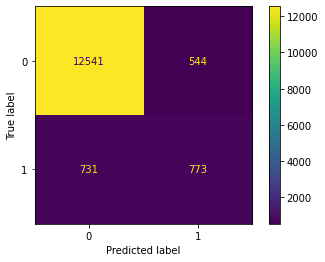

In [36]:
#creates the model
from sklearn.neural_network import MLPClassifier
nodes = len(df.columns)
mlp = MLPClassifier(hidden_layer_sizes=(nodes,nodes,nodes), activation='relu', solver='adam', max_iter=500)
#fits model to the training data
mlp.fit(X_train, y_train)
#makes predictions on new testing data
predict_test = mlp.predict(X_test)

#shows results of predictions of training data
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(y_test, predict_test))

This model has the highest accuracy out of all the models, the most amount of true negatives, and the least amount of false negatives.

### Logistic Regression

Then I tried logistic regression because the dependent variable is binary, it is either rock music or not rock music with nothing in between.

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     13085
         1.0       0.56      0.28      0.37      1504

    accuracy                           0.90     14589
   macro avg       0.74      0.63      0.66     14589
weighted avg       0.88      0.90      0.89     14589



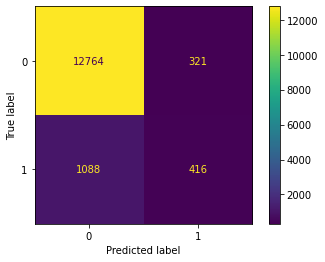

In [37]:
#creates the model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)
#fits model to the training data
lr.fit(X_train, y_train)
#makes predictions on new testing data
predict_test = lr.predict(X_test)

#shows results of predictions of training data
cm = confusion_matrix(y_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(y_test, predict_test))

This model has the most amount of true positives and the least amount of false positives.

### K Nearest Neighbor

KNN I chose this because it is a popular and simple model for classification.

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     13085
         1.0       0.50      0.27      0.35      1504

    accuracy                           0.90     14589
   macro avg       0.71      0.62      0.65     14589
weighted avg       0.88      0.90      0.88     14589



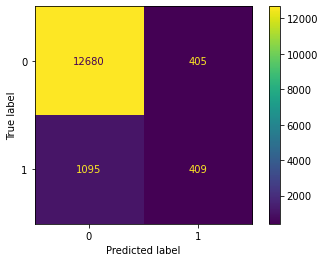

In [38]:
#creates the model
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
#fits model to the training data
neigh.fit(X_train, y_train)
#makes predictions on new testing data
predict_test = neigh.predict(X_test)

#shows results of predictions of training data
cm = confusion_matrix(y_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(y_test, predict_test))

This model has the least amount of true negatives, the most amount of false negatives, and the lowest accuracy score.

### Random Forest Classifier

Random Forest Classifier I chose this because it is popular for classification and good with large datasets

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     13085
         1.0       0.52      0.33      0.41      1504

    accuracy                           0.90     14589
   macro avg       0.72      0.65      0.68     14589
weighted avg       0.88      0.90      0.89     14589



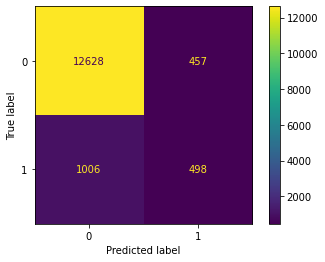

In [39]:
#creates the model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
#fits model to the training data
rfc.fit(X_train, y_train)
#makes predictions on new testing data
predict_test = rfc.predict(X_test)

#shows results of predictions of training data
cm = confusion_matrix(y_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(y_test, predict_test))

This model had very middle of the road results.

### Improving Accuracy

In [40]:
from sklearn.feature_selection import SelectFromModel
fetSel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
fetSel.fit(X_train, y_train)
fetSel.get_support()

array([False, False, False,  True, False,  True, False, False,  True,
       False, False, False])

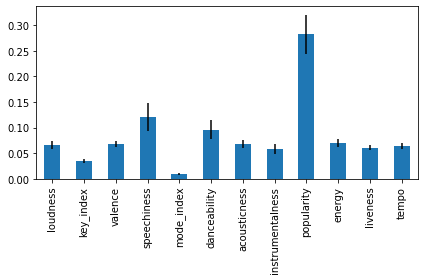

In [41]:
#feature_names = [f"feature {i}" for i in range(x_train.shape[1])]
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
forest_importances = pd.Series(importances, index=df[predictors].columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
fig.tight_layout()

Just because you tried a few models doesn't mean it's as good as it's gonna get. Try doing some additional feature engineering, dropping some additional columns.

Some sklearn modules like RandomForest have an attribute called "feature_importances_ ", which ranks which features were most and least important in the model. That can give you some clues on what to try dropping or adding first. Maybe squaring an important feature might give it more weight and lead to a better evaluation metric...?

In [42]:
df = df.drop(columns=['mode_index', 'key_index'])
df['popularity'] = df['popularity'].pow(1/2)
df['speechiness'] = df['speechiness'].pow(1/2)
df['danceability'] = df['danceability'].pow(1/2)


In [43]:
predictors = list(set(list(df.columns))-set(target))
#changes the dataframe into two numpy arrays
X = df[predictors].values
y = df[target].values
#Change y from a column-vector to a 1d array
y = np.ravel(y)

#split x and y arrays into training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=40)

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95     13085
         1.0       0.60      0.45      0.52      1504

    accuracy                           0.91     14589
   macro avg       0.77      0.71      0.74     14589
weighted avg       0.90      0.91      0.91     14589



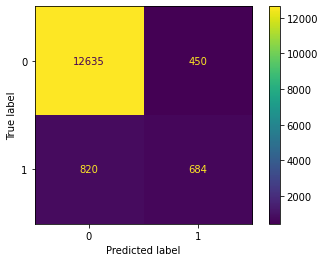

In [44]:
nodes = len(df.columns)
mlp = MLPClassifier(hidden_layer_sizes=(nodes,nodes,nodes), activation='relu', solver='adam', max_iter=500)
#fits model to the training data
mlp.fit(X_train, y_train)
#makes predictions on new testing data
predict_test = mlp.predict(X_test)

#shows results of predictions of training data

cm = confusion_matrix(y_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(y_test, predict_test))

In [55]:
total = cm[0][1] + cm[0][0] + cm[1][0] + cm[1][1]
print( (cm[0][0] + cm[0][1]) / total)
print((cm[0][0] + cm[1][1]) / total) 

0.8969086297895675
0.9129481115909247


The first number is the accuracy of the model if it predicted that the song is never rock, the second number is the actual accuracy of the model

After looking at the results, I believe the best model to use would be the multi-layer perceptron classifier. The reasoning behind this is it had the best accuracy score out of all four, a competitive true postive score, the highest true negative score. Overall it has very competitve precision and recall scores.